<a href="https://colab.research.google.com/github/nuel-d1/Image-Classifier/blob/master/Image_Classifier_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from torchvision import datasets, transforms, models
import torch
from PIL import Image
from torch import nn, optim
from collections import OrderedDict

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#Downloading and extracting the dataset
!wget https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
!tar -xvzf flower_data.tar.gz

Streaming output truncated to the last 5000 lines.
train/75/image_02096.jpg
train/75/image_02181.jpg
train/75/image_02079.jpg
train/75/image_02129.jpg
train/75/image_02073.jpg
train/75/image_02162.jpg
train/75/image_02082.jpg
train/75/image_02098.jpg
train/75/image_02080.jpg
train/75/image_02150.jpg
train/75/image_02159.jpg
train/75/image_02158.jpg
train/75/image_02163.jpg
train/75/image_02160.jpg
train/75/image_02134.jpg
train/75/image_02101.jpg
train/75/image_02171.jpg
train/75/image_02117.jpg
train/75/image_02137.jpg
train/75/image_02136.jpg
train/75/image_02102.jpg
train/75/image_02146.jpg
train/75/image_02177.jpg
train/75/image_02110.jpg
train/75/image_02123.jpg
train/75/image_02105.jpg
train/75/image_02076.jpg
train/75/image_02116.jpg
train/75/image_02170.jpg
train/75/image_02132.jpg
train/75/image_02122.jpg
train/75/image_02090.jpg
train/75/image_02138.jpg
train/75/image_02097.jpg
train/75/image_02106.jpg
train/75/image_02084.jpg
train/75/image_02087.jpg
train/75/image_02120.jpg

In [0]:
#data_dir = 'flower_data'
train_dir = '/content/train'
valid_dir = '/content/valid'
test_dir = '/content/test'

In [0]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomPerspective(),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# TODO: Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform = train_transforms)

valid_dataset = datasets.ImageFolder(valid_dir, transform = test_transforms)

test_dataset = datasets.ImageFolder(test_dir, transform = test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size = 64)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64)

In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [0]:
#Loading pre-trained model
model = models.densenet121(pretrained = True)



#freezing model parameters to avoid backpropagation through
for params in model.parameters():
    params.requires_grad = False
    

#designing custom classifier
custom_classifier = nn.Sequential(OrderedDict([
    ('input', nn.Linear(1024, 500)),
     ('ReLu', nn.ReLU()),
     ('dropout', nn.Dropout()),
     ('output', nn.Linear(500, 102)),
     ('function', nn.LogSoftmax(dim=1))
]))
model.classifier = custom_classifier
model.class_to_idx = train_dataset.class_to_idx
model.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [0]:
#defining loss function
criterion = nn.NLLLoss()
#defining optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.002)

In [0]:
# Training the network

# keeping track of training and test loss
epochs = 15
steps = 0
train_loss = 0
print_count = 10
for epoch in range(epochs):
  for images, labels in train_dataloader:
        steps+=1
        # moving tensors to gpu
        images, labels = images.to(device), labels.to(device)
        # clearing the gradient of all optimized variables
        optimizer.zero_grad()
        # forward pass
        output = model.forward(images)
        # calculate loss
        loss = criterion(output, labels)
        # Backpropagation
        loss.backward()
        # Optimize the variables
        optimizer.step()
        # update training loss
        train_loss += loss.item()

        if steps % print_count == 0:
          # validation
          test_loss = 0
          accuracy = 0
          # set the model to evaluation mode
          model.eval()
          with torch.no_grad():
              for v_images, v_labels in valid_dataloader:
                  v_images, v_labels = v_images.to(device), v_labels.to(device)
                  
                  # Forward pass
                  v_output = model.forward(v_images)
                  v_loss = criterion(v_output, v_labels)
                  test_loss += v_loss.item()

                  # Probabililty of Accuracy
                  prediction = torch.exp(v_output)
                  match = (v_labels.data == prediction.max(dim=1)[1])
                  accuracy += match.type(torch.FloatTensor).mean()
 
          print ('Epoch: %d | Training loss: %.4f | Test Loss: %.4f | Accuracy: %.4f' % 
                 (epoch+1, train_loss/64, test_loss/len(valid_dataloader), accuracy/len(valid_dataloader)))
          train_loss = 0
          #return model to training mode
          model.train()
           

print("\nTraining process is now complete!!")
print("Prediction accuracy = {:.1f} %".format((accuracy/len(valid_dataloader)*100)))

Epoch: 1 | Training loss: 0.7272 | Test Loss: 4.3265 | Accuracy: 0.1076
Epoch: 1 | Training loss: 0.6777 | Test Loss: 4.1010 | Accuracy: 0.1445
Epoch: 1 | Training loss: 0.6424 | Test Loss: 3.7282 | Accuracy: 0.1823
Epoch: 1 | Training loss: 0.5930 | Test Loss: 3.3907 | Accuracy: 0.3042
Epoch: 1 | Training loss: 0.5544 | Test Loss: 2.9972 | Accuracy: 0.4144
Epoch: 1 | Training loss: 0.5040 | Test Loss: 2.6947 | Accuracy: 0.4226
Epoch: 1 | Training loss: 0.4716 | Test Loss: 2.3097 | Accuracy: 0.5394
Epoch: 1 | Training loss: 0.4245 | Test Loss: 2.0100 | Accuracy: 0.5644
Epoch: 1 | Training loss: 0.4095 | Test Loss: 1.8097 | Accuracy: 0.5924
Epoch: 1 | Training loss: 0.3471 | Test Loss: 1.6038 | Accuracy: 0.6597
Epoch: 2 | Training loss: 0.3557 | Test Loss: 1.5013 | Accuracy: 0.6681
Epoch: 2 | Training loss: 0.3037 | Test Loss: 1.3791 | Accuracy: 0.7117
Epoch: 2 | Training loss: 0.2959 | Test Loss: 1.2432 | Accuracy: 0.7256
Epoch: 2 | Training loss: 0.2917 | Test Loss: 1.2000 | Accuracy:

In [0]:
# TODO: Do validation on the test set
t_accuracy = 0
model.eval()
with torch.no_grad():
  for batch, (images, labels) in enumerate(test_dataloader):
    images, labels = images.to(device), labels.to(device)
    t_output = model(images)
  
    prediction = torch.exp(t_output)
    t_match = (labels.data==prediction.max(dim=1)[1])
    t_accuracy += t_match.type(torch.FloatTensor).mean()
    
    print("batch {}".format(batch+1))
  print("\nPrediction accuracy ={:.1f}% ".format((t_accuracy/len(test_dataloader)*100)))

batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13

Prediction accuracy =90.4% 


In [0]:
# TODO: Save the checkpoint
checkpoint = {'epoch': epochs,
              'model': model,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'training loss': train_loss,
              'class_to_idx': model.class_to_idx
              }

torch.save(checkpoint, 'checkpoint.pth')


In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location=torch.device('cpu'))
    n_model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for parameter in model.parameters():
      parameter.requires_grad = False
    
    model.eval()
    return n_model

    
n_model = load_checkpoint('checkpoint.pth')
print(n_model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [0]:
#INFERENCE FOR CLASSIFICATION

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    try:
        im = Image.open(image)
        # TODO: Process a PIL image for use in a PyTorch model
        p_transform = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])
        image = ImageFolder(im, tranform = p_transform)
        return image
    except IOError:
        pass
   

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    try:
        im = Image.open(image)
        # TODO: Process a PIL image for use in a PyTorch model
        p_transform = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                         ])
        img = p_transform(im)
        return img
    except IOError:
        pass
   

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    ax.axis('off')
    
    return ax

In [0]:
#CLASS PREDICTION

def predict(image_path, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    model.eval()
    with torch.no_grad():
      # TODO: Implement the code to predict the class from an image file
        image = process_image(image_path)
        index_to_class = {value: key for key, value in model.class_to_idx.items()}
        output = torch.exp(n_model(image[None]))
        probs, indices = output.topk(topk)
        
        #obtaining probability
        stats = []
        for j in probs:
            for bin in j.numpy():
                stats+=[bin]
                
        #obtaining class indices
        top_5 = []
        f_name = []
        for i in indices:
            top_5+= [index_to_class[idx] for idx in i.numpy()]
            f_name+= [cat_to_name[k] for k in top_5]
    
    return stats, top_5, f_name
          

In [0]:
# TODO: Display an image along with the top 5 classes
def visualization(image_path):
    predict(image_path)
    image = process_image(image_path)
    ps, classes, flower = predict(image_path)
    fig, (ax1,ax2) = plt.subplots(figsize = [9,4], ncols=2, tight_layout = True)
    imshow(image, ax = ax1)
    sb.barplot(x = ps, y = flower, color = sb.color_palette()[0], ax = ax2)
    
    plt.show()

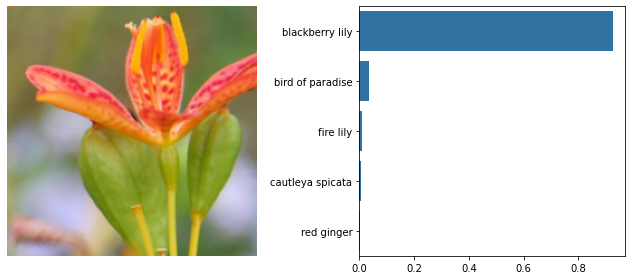

In [0]:
image_path_2 = test_dir + '/20/image_04910.jpg'
image_path_4 = test_dir + '/102/image_08030.jpg'
visualization(image_path_4)